# Predicting Product Review Scores Using Transformer Models

## Project Description

This project aims to predict product review scores based on the review's title and content using machine learning techniques. The goal is to infer a continuous score between 0 and 10 for each review. The dataset consists of a training set containing review titles, content, and their associated scores, while the test set includes titles and content without scores.

The recommended approach utilizes the `transformers` library, exploring models such as DistilBERT, ALBERT, and GPT-2. While fine-tuning these models is encouraged for more realistic applications, using frozen weights is sufficient to meet the project's baseline. The task involves extracting embeddings from the pretrained transformers and saving them for subsequent model training. The code leverages the PyTorch deep learning framework and can be run on modern GPUs for efficient computation.

## Code Description

This script tackles an NLP problem where product reviews are used to predict scores ranging from 0 to 10. The preprocessing step involves using a lightweight spaCy model to clean the text, including stop-word removal, lemmatization, and handling negations. The preprocessed text data is split into training and validation sets in a 9:1 ratio.

The regression task is performed using the `DistilBERT` model, a variant of BERT. In the first layer of the regression network, the input is tokenized using the BERT tokenizer and passed through the model to obtain the CLS token representation in the hidden layer, which is then regularized using a dropout layer. Before producing the final output, this representation is passed through a linear layer. The network is trained in an alternating loop that calls `model.train()` and `model.eval()` to monitor the training process and avoid overfitting.

First we import the used libaries: 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Add any other imports you need here
from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
import torch.optim as optim
import math
import numpy as np
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import string

In [3]:
# Load the training data
train_df = pd.read_csv('/train.csv')

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_df['sentence'].tolist(), truncation=True, padding=True, max_length=512)

train_df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

,title,sentence,score
0,not really sayin anything,this movie is ok but its not teachin anything ...,4.657854
1,Good for the cost.,"This item is cheap, easy to use, and has lots ...",7.531274
2,Great little appliance,I love this chopper as it's the right size for...,9.584762
3,bloated!,there is about 10 minutes of real content in t...,1.016373
4,Long Live Chris!,I'm so glad there are still people out there w...,9.605730


In [4]:
train_df.describe()

,score
count,12500.000000
mean,4.967809
std,3.231226
min,0.000000
25%,2.036119
50%,4.795231
75%,8.122389
max,10.000000


In [5]:
train_df.isnull().mean()


title       0.0
sentence    0.0
score       0.0
dtype: float64

In [6]:
len(train_df['score'].unique())


12112

In [7]:
train_df['score'].value_counts(normalize=True)


score
0.000000     0.02128
10.000000    0.00992
2.737024     0.00008
2.063743     0.00008
2.904216     0.00008
              ...   
7.516234     0.00008
2.050823     0.00008
1.568555     0.00008
9.411560     0.00008
9.574965     0.00008
Name: proportion, Length: 12112, dtype: float64

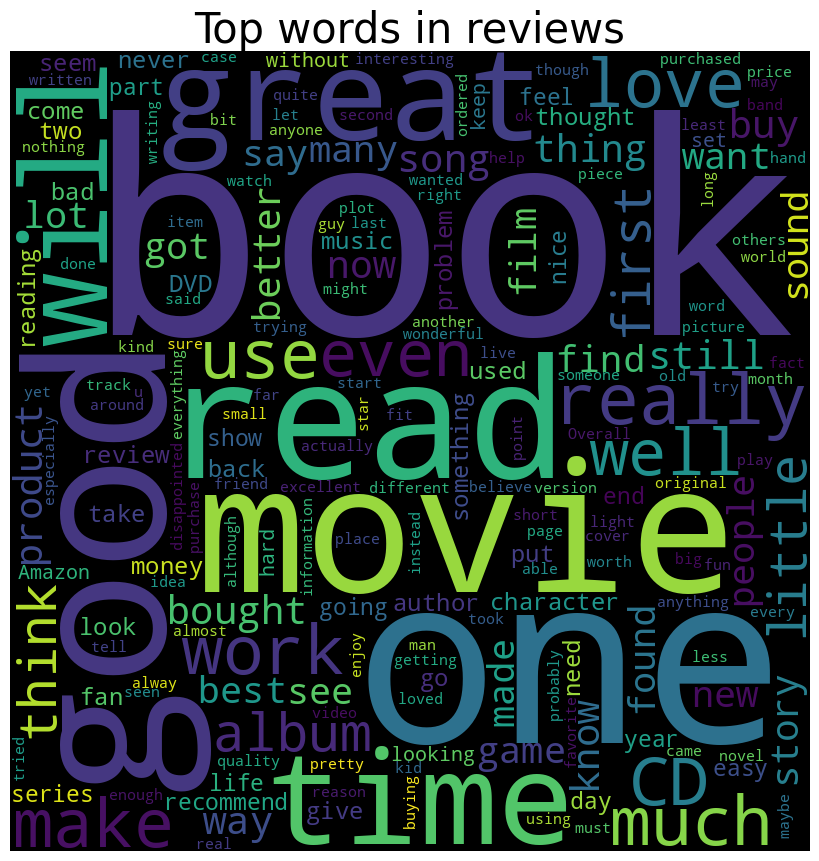

In [8]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.show()
wordCloud_generator(train_df['sentence'], title="Top words in reviews")


In [9]:
X = train_df['sentence'].copy()
y = train_df['score'].copy().astype(float)

In [10]:
apposV2 = {
"are not" : "are not",
"ca" : "can",
"could n't" : "could not",
"did n't" : "did not",
"does n't" : "does not",
"do n't" : "do not",
"had n't" : "had not",
"has n't" : "has not",
"have n't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"is n't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"might n't" : "might not",
"must n't" : "must not",
"sha" : "shall",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"should n't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"were n't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"wo" : "will",
"would n't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"was n't": "was not",
"we'll":"we will",
"did n't": "did not"
}
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [11]:
import nltk
from nltk.corpus import stopwords

In [12]:

nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])
nltk.download('stopwords')
stop = stopwords.words('english')
def cleanData(reviews):
    all_=[]
    for review in reviews:
        lower_case = review.lower() #lower case the text
        lower_case = lower_case.replace(" n't"," not") #correct n't as not
        lower_case = lower_case.replace("."," . ")
        lower_case = ' '.join(word.strip(string.punctuation) for word in lower_case.split()) #remove punctuation
        words = lower_case.split() #split into words
        words = [word for word in words if word.isalpha()] #remove numbers
        split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
        split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
        split = [word for word in split if word not in stop] #remove stop words
        reformed = " ".join(split) #join words back to the text
        doc = nlp(reformed)
        reformed = " ".join([token.lemma_ for token in doc]) #lemmatiztion
        all_.append(reformed)
    df_cleaned = pd.DataFrame()
    df_cleaned['clean_reviews'] = all_
    return df_cleaned['clean_reviews']
X_cleaned = cleanData(X)
X_cleaned.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    movie ok teachin anything do not tell sny hist...
1    item cheap easy use lot color option work well...
2    love chopper right size need match red kitchen...
3    minute real content documentary stretch fill c...
4    glad still people appreciate great music work ...
Name: clean_reviews, dtype: object

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


In [14]:
train_encodings = tokenizer(X_cleaned.tolist(), truncation=True, padding=True, max_length=512)


In [17]:
train_df['score'] = train_df['score'].astype(float)



In [18]:
class RegressionDataset(Dataset):
    def __init__(self, encodings, scores):
        self.encodings = encodings
        self.scores = scores

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['score'] = torch.tensor(self.scores[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.scores)

In [19]:
dataset = RegressionDataset(train_encodings, train_df['score'].tolist())


In [20]:
# Split the data into training and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [22]:
class DistilBertRegressor(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DistilBertRegressor, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(self.distilbert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        dropout_output = self.dropout(hidden_state)
        linear_output = self.linear(dropout_output)
        return linear_output

In [23]:
model = DistilBertRegressor()
model = model.cuda()  # Move the model to GPU if available
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [24]:
def train(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        scores = batch['score'].cuda()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

In [25]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            scores = batch['score'].cuda()

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), scores)

            total_loss += loss.item()
    return total_loss / len(data_loader)


In [42]:
epochs = 10
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, test_loader, criterion)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.64it/s]


Epoch 1/10, Training Loss: 1.3790941845456308, Validation Loss: 31.57345369720459


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch 2/10, Training Loss: 0.9621770136396993, Validation Loss: 37.36694806671142


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.58it/s]


Epoch 3/10, Training Loss: 0.7843477555381303, Validation Loss: 34.22034973144531


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch 4/10, Training Loss: 0.6642837523990734, Validation Loss: 40.2197103729248


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.59it/s]


Epoch 5/10, Training Loss: 0.5406114619690925, Validation Loss: 33.419380798339844


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.56it/s]


Epoch 6/10, Training Loss: 0.46340630846944725, Validation Loss: 38.80915962219238


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch 7/10, Training Loss: 0.44269967634781177, Validation Loss: 40.378085960388184


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.55it/s]


Epoch 8/10, Training Loss: 0.40725213835354557, Validation Loss: 37.04244652557373


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.64it/s]


Epoch 9/10, Training Loss: 0.36558498689820146, Validation Loss: 40.77431811523437


Evaluating: 100%|██████████| 125/125 [00:09<00:00, 13.69it/s]

Epoch 10/10, Training Loss: 0.3234334358606826, Validation Loss: 38.62500439453125


In [43]:
from torch.cuda.amp import autocast, GradScaler


In [45]:
# Load the test data
test_df = pd.read_csv('/test_no_score.csv')
test_encodings = tokenizer(test_df['sentence'].tolist(), truncation=True, padding=True, max_length=512)
test_dataset = RegressionDataset(test_encodings, [0] * len(test_df))  # Dummy labels
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Generate predictions
use_mixed_precision = True

model.eval()
predicted_scores = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with autocast(enabled=use_mixed_precision):
            outputs = model(input_ids, attention_mask)
            predicted_scores.extend(outputs.squeeze().cpu().numpy())

submission1_txt = ''
for title, sentence, score in zip(test_df['title'], test_df['sentence'], predicted_scores):
    submission1_txt += f"{score}\n"

with open('/submission1.txt', 'w') as f:
    f.write(submission1_txt)

print("Submission saved to submission1.txt")



Submission saved to submission1.txt
